In [92]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамблиd
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna


%matplotlib inline
plt.style.use('seaborn')

/var/folders/g1/qmxhdvlx3kx97plxw0bx1vnw0000gn/T/ipykernel_30882/3200764734.py:23: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



In [23]:
#Загружаем данные
data = pd.read_csv('data/_train.csv', sep=',')

In [24]:
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [25]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Логистическая регрессия

In [27]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


# Подбор гиперпараметров

### <center> **GridSearchCV**

In [49]:
from sklearn.model_selection import GridSearchCV
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.12,0.11, 0.3, 0.5, 0.7, 0.9]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.12, 0.11, 0.3, 0.5, 0.7, 0.9]}
]
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5,  #количество фолдов кросс-валидации
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

/Users/stevgenia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/stevgenia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/stevgenia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/stevgenia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/stevgenia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/stevgenia/Lib

CPU times: user 915 ms, sys: 177 ms, total: 1.09 s
Wall time: 8min 39s
accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}


In [51]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.76


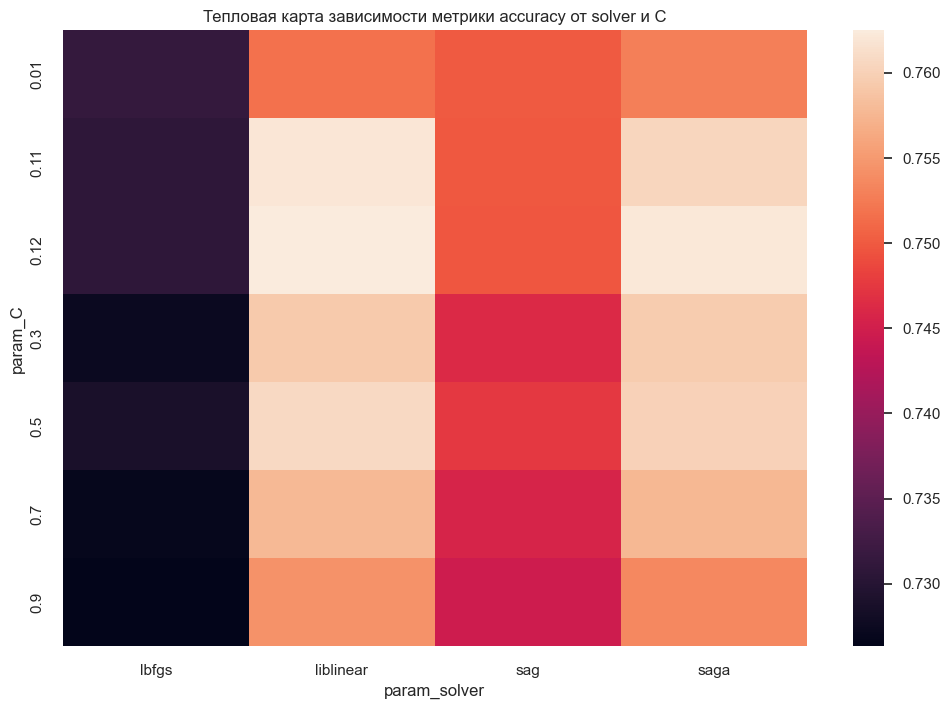

In [50]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

In [60]:
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.125, 0.127, 0.128]}
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5,  #количество фолдов кросс-валидации
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

/Users/stevgenia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/stevgenia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/stevgenia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/stevgenia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/stevgenia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/stevgenia/Lib

CPU times: user 311 ms, sys: 46.2 ms, total: 357 ms
Wall time: 1min 39s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.127, 'penalty': 'l2', 'solver': 'liblinear'}


С помощью подбора сетки удалось увеличиль accuracy и f-score на 0.1

### <center> **RandomizedSearchCV**

In [62]:
#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 0.1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

/Users/stevgenia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/stevgenia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/stevgenia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/stevgenia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/stevgenia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/stevgenia/Lib

CPU times: user 3.95 s, sys: 66.9 ms, total: 4.01 s
Wall time: 1min 54s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.030000000000000006}


С помощью подбора удалось увеличиль accuracy и f-score на 0.1

# RandomForest

In [75]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.80


По данным тренировочной выборки, видим признаки переобучения

# RandomizedSearchCV

In [64]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: user 684 ms, sys: 194 ms, total: 878 ms
Wall time: 13.1 s
accuracy на тестовом наборе: 0.73
f1_score на тестовом наборе: 0.75
Наилучшие значения гиперпараметров: {'min_samples_leaf': 10, 'max_depth': 3, 'criterion': 'entropy'}


Значения accuracy и f1_score уменьшились, но исчезли прищнаки переобучения

# GridSearchCV

In [76]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: user 1.25 s, sys: 152 ms, total: 1.4 s
Wall time: 19.6 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


Значения acuracy и f-score при выбранных параметрах выше, чем в случае RandomizedSearchCV

# Hyperopt

In [79]:
space={'n_estimators': hp.quniform('n_estimators', 100, 300, 1),
       'max_depth' : hp.quniform('max_depth', 15, 40, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 7, 1)
      }

In [80]:
# зафксируем random_state
random_state = int(42)
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [81]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [00:27<00:00,  1.36s/trial, best loss: -0.9743433109346366]
Наилучшие значения гиперпараметров {'max_depth': 22.0, 'min_samples_leaf': 3.0, 'n_estimators': 201.0}
CPU times: user 27 s, sys: 262 ms, total: 27.3 s
Wall time: 27.3 s


In [82]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.97
accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80


Значения на тестовом наборе данных равны значениям, полученным при использование GridSearchCV, однако значение f1_score на обучающем наборе данных стало выше на 0.3

# OPTUNA

In [83]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 1)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [86]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-01-24 19:53:47,310] A new study created in memory with name: RandomForestClassifier
[I 2023-01-24 19:53:49,151] Trial 0 finished with value: 0.9457317073170731 and parameters: {'n_estimators': 248, 'max_depth': 36, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9457317073170731.
[I 2023-01-24 19:53:50,582] Trial 1 finished with value: 0.9224688355123138 and parameters: {'n_estimators': 214, 'max_depth': 31, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9457317073170731.
[I 2023-01-24 19:53:51,386] Trial 2 finished with value: 0.9551418980775098 and parameters: {'n_estimators': 105, 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9551418980775098.
[I 2023-01-24 19:53:52,238] Trial 3 finished with value: 0.9205962884088835 and parameters: {'n_estimators': 125, 'max_depth': 40, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.9551418980775098.
[I 2023-01-24 19:53:53,154] Trial 4 finished with value: 0.9561510353227771 and parameters: {'n_

CPU times: user 30.7 s, sys: 315 ms, total: 31.1 s
Wall time: 31.1 s


In [87]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 180, 'max_depth': 30, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.97


In [89]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80


In [90]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

[I 2023-01-24 21:32:53,832] Trial 20 finished with value: 0.9455098934550991 and parameters: {'n_estimators': 271, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 16 with value: 0.9746874046965537.
[I 2023-01-24 21:32:55,904] Trial 21 finished with value: 0.9744058500914077 and parameters: {'n_estimators': 261, 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 16 with value: 0.9746874046965537.
[I 2023-01-24 21:32:57,660] Trial 22 finished with value: 0.9731543624161073 and parameters: {'n_estimators': 224, 'max_depth': 23, 'min_samples_leaf': 3}. Best is trial 16 with value: 0.9746874046965537.
[I 2023-01-24 21:32:59,736] Trial 23 finished with value: 0.9579780755176613 and parameters: {'n_estimators': 274, 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 16 with value: 0.9746874046965537.
[I 2023-01-24 21:33:01,313] Trial 24 finished with value: 0.9743589743589743 and parameters: {'n_estimators': 195, 'max_depth': 29, 'min_samples_leaf': 3}. Best is trial 16 with va

CPU times: user 17.7 s, sys: 193 ms, total: 17.9 s
Wall time: 17.9 s


In [91]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

Вывод: значения f_score и accuracy для HIPEROPT и OPTUNA равны, данные способы подбора гиперпараметров дают лучшие результаты.